Compute a flag based on seed clustereing

In [733]:
import os
from pathlib import Path
import numpy as np
import requests
import pandas as pd

In [734]:
# Set path to data folder
current_dir = Path(os.getcwd())
DATA_DIR = os.path.join(current_dir.parent.parent, 'data-regen-rangers')
DATA_DIR_GITCOIN = os.path.join(current_dir.parent.parent, 'data-gitcoin')
GRANT_ROUND_ID = '0x984e29dCB4286c2D9cbAA2c238AfDd8A191Eefbc'
ODC_DATA_DIR = os.path.join(current_dir.parent.parent.parent, 'data')

PATH_TO_VOTES = os.path.join(DATA_DIR_GITCOIN, 'citizen-votes.csv')
# PATH_TO_GRANTS = os.path.join(DATA_DIR, "all-allo-rounds.csv")
# PATH_TO_PROJECTS = os.path.join(DATA_DIR, "projects_QmQurt.csv")

In [735]:
df_matching_address = pd.read_csv(f'../output_gitcoin/full_features/voters_features_{GRANT_ROUND_ID}.csv')
df_votes = pd.read_csv(f'../output_gitcoin/full_features/votes_features_citizen_{GRANT_ROUND_ID}.csv')
df_seed = pd.read_csv(os.path.join(DATA_DIR, 'seed_wallet_citizen.csv'))

In [736]:
df_matching_address.columns

Index(['address', 'seed_same_naive', 'seed_same', 'seed_suspicious',
       'less_5_tx', 'less_10_tx', 'interacted_other_ctbt', 'lcs',
       'cluster_size_lcs', 'mean_score_lcs', 'max_score_lcs', 'has_lcs',
       'count_interaction_with_pool', 'count_interaction_with_toxic',
       'interact_less_5tx', 'has_interaction_toxic', 'has_no_pool_interaction',
       'count_interaction_with_airdrop_m', 'is_airdrop_master',
       'count_interaction_with_tornado', 'count_interaction_with_disperse',
       'has_interaction_airdrop_m', 'has_interaction_tornado',
       'has_interaction_disperse', 'flagged'],
      dtype='object')

In [737]:
df_votes.columns

Index(['block_timestamp', 'tx_hash', 'voter', 'project', 'amount_usd',
       '__row_index', 'seed_same_naive', 'seed_same', 'seed_suspicious',
       'less_5_tx', 'less_10_tx', 'interacted_other_ctbt', 'lcs',
       'cluster_size_lcs', 'mean_score_lcs', 'max_score_lcs', 'has_lcs',
       'count_interaction_with_pool', 'count_interaction_with_toxic',
       'interact_less_5tx', 'has_interaction_toxic', 'has_no_pool_interaction',
       'count_interaction_with_airdrop_m', 'is_airdrop_master',
       'count_interaction_with_tornado', 'count_interaction_with_disperse',
       'has_interaction_airdrop_m', 'has_interaction_tornado',
       'has_interaction_disperse', 'flagged', 'stakeridoo_detected',
       'doge_detected', 'odc_detected'],
      dtype='object')

In [738]:
df_seed.head(2)

,EOA,from_address,to_address
0,0x000000006f457c0f8f560333d9c2877287d92a92,0xacd03d601e5bb1b275bb94076ff46ed9d753435a,0x000000006f457c0f8f560333d9c2877287d92a92
1,0x000128fa45d79dc9af8016da242781f12c363fd5,0xe4edb277e41dc89ab076a1f049f4a3efa700bce8,0x000128fa45d79dc9af8016da242781f12c363fd5


EOA is the address of the citizen voter. From address is the address of the seeder.

In [739]:
print(df_matching_address['address'].shape)
print(df_matching_address['address'].unique().shape)
print(df_seed['EOA'].shape)
print(df_seed['EOA'].unique().shape)

(17023,)
(17023,)
(13820,)
(13820,)


In [740]:
np.setdiff1d(df_matching_address['address'], df_seed['EOA'])

array(['0x00773dcbbbb0ffb5d669e990c35d8339f080d1ee',
       '0x00781d50a170f09db92965094a1fa13bb119600b',
       '0x008076097a7a46993ecb1d1c21a7d3dd655afae3', ...,
       '0xffc0856eef7b73d0613bdd0f20fafa8b82f8dde7',
       '0xffd5a033e8ed8db8f63a1d19e189ffb82a06a779',
       '0xfff0016550753ce0b4b70704ae88aaf154bec4bf'], dtype=object)

**These addresses don't have any incomming transactions this explains what they don't have a seed wallet. We would need to explore normal transactions to find the seed wallet.**



We will consider that these wallet can't be flagged with the new seed clustering algorithm.

In [741]:
np.setdiff1d(df_matching_address['address'], df_votes.voter.unique()).shape

(0,)

In [742]:
df_count_seed = df_seed.groupby('from_address').count().sort_values(by='EOA', ascending=False).drop(columns='to_address')
df_count_seed.head(2)

,EOA
from_address,
0x80c67432656d59144ceff962e8faf8926599bcf8,3148
0xacd03d601e5bb1b275bb94076ff46ed9d753435a,2980


In [743]:
# load labels for EOA to know if it is a bridge or an exchange or something else
df_labels = pd.read_csv(os.path.join(ODC_DATA_DIR, 'address_labels_citizen.csv'), usecols=['address', 'tag', 'sub_type'])
df_labels_test = pd.read_csv(os.path.join(ODC_DATA_DIR, 'address_labels_citizen_test.csv'), usecols=['address', 'tag', 'sub_type'])
df_labels = pd.concat([df_labels, df_labels_test])
print(df_labels.shape)
df_labels.drop_duplicates(inplace=True)
print(df_labels.shape)

(105, 3)
(104, 3)


In [744]:
df_labels['cex_or_bridge'] = df_labels['tag'].apply(lambda x: True if x in ['cex_or_bridge', 'bridge', 'cex'] else False)

In [745]:
array_address_cex_or_bridge = df_labels[df_labels['cex_or_bridge']]['address'].unique()
print(len(array_address_cex_or_bridge))

32


In [746]:
df_count_seed['cex_or_bridge'] = df_count_seed.index.isin(array_address_cex_or_bridge)
df_count_seed.head(2)

,EOA,cex_or_bridge
from_address,,
0x80c67432656d59144ceff962e8faf8926599bcf8,3148,True
0xacd03d601e5bb1b275bb94076ff46ed9d753435a,2980,True


Here we compute some metric to see how many sybil could be flagged with the new seed clustering algorithm.
These is not the best approach because we should look at these suspicious addresses and their votes to see if they are sybil or not.

In [747]:
df_suspicous_seed = df_count_seed.loc[np.logical_and(~df_count_seed['cex_or_bridge'], df_count_seed['EOA'] > 2)]
print(df_suspicous_seed.head(2))
print(f'number of suspicious seeding wallets: {df_suspicous_seed.shape[0]}')
print(f'number of expected sybils: {df_suspicous_seed["EOA"].sum()}')

                                            EOA  cex_or_bridge
from_address                                                  
0x17f52a50227ea7aa6042eaae44c84a9a9d59d092   67          False
0x4a1939dc1de524ff01980a911f0f4d65ce7a27ba   25          False
number of suspicious seeding wallets: 123
number of expected sybils: 636


In [748]:
df_suspicous_seed = df_count_seed.loc[np.logical_and(~df_count_seed['cex_or_bridge'], df_count_seed['EOA'] > 1)]
print(f'number of suspicious seeding wallets: {df_suspicous_seed.shape[0]}')
print(f'number of expected sybils: {df_suspicous_seed["EOA"].sum()}')

number of suspicious seeding wallets: 313
number of expected sybils: 1016


Above 3 seeding of voters we can expect the voter address to be a sybil. At 2 we may not be sure so the best way is to look at the votes.

In [749]:
array_suspicous_seed = df_suspicous_seed.index.values
array_sus_seed_eoa = df_seed[df_seed['EOA'].isin(array_suspicous_seed)].EOA.unique()
array_sus_seed_from = df_seed[df_seed['from_address'].isin(array_suspicous_seed)].from_address.unique()
suspicious_voter = df_seed[np.logical_or(df_seed['EOA'].isin(array_suspicous_seed), df_seed['from_address'].isin(array_suspicous_seed))]['EOA'].unique()
print(f'number of suspicious voters: {len(suspicious_voter)}')
print(f'number of suspicious_seeder {len(array_suspicous_seed)}')

number of suspicious voters: 1200
number of suspicious_seeder 313


In [750]:
df_seed_suspicious = df_seed[np.logical_or(df_seed['EOA'].isin(array_suspicous_seed), df_seed['from_address'].isin(array_suspicous_seed))].copy()

In [751]:
cluster = []
for group in df_seed_suspicious.groupby('from_address'):
    small_cluster = np.array([])
    if group[0] in array_address_cex_or_bridge:
        small_cluster = group[1]['EOA'].unique()
    else:
        small_cluster = np.append(group[1]['EOA'].unique(), group[0])
    cluster.append(small_cluster)

In [752]:
df_seed_suspicious.from_address.unique().shape[0]

394

In [753]:
assert len(cluster) == df_seed_suspicious.from_address.unique().shape[0]
print(f'number of suspicious clusters: {len(cluster)} before merging')

number of suspicious clusters: 394 before merging


Now we merge clusters that contains at least one common address

In [754]:
def merge_cluster(cluster):
    new_cluster = []
    cluster_merged = []
    for i in range(len(cluster)):
        if not i in cluster_merged:
            small_cluster = cluster[i]
            for j in range(i+1, len(cluster)):
                if len(np.intersect1d(small_cluster, cluster[j])) > 0:
                    small_cluster = np.append(small_cluster, cluster[j])
                    cluster_merged.append(j)
            new_cluster.append(np.unique(small_cluster))
    return new_cluster

In [755]:
def merge_cluster_full(cluster):
    print(len(cluster))
    new_cluster = merge_cluster(cluster)
    while len(new_cluster) != len(cluster):
        cluster = new_cluster
        new_cluster = merge_cluster(cluster)
        print(len(new_cluster))
    return new_cluster

In [756]:
new_cluster = merge_cluster_full(cluster)

394


162
161
161


In [757]:
def max_length_cluster(cluster):
    max_length = 0
    for i in range(len(cluster)):
        if len(cluster[i]) > max_length:
            max_length = len(cluster[i])
    return max_length

print(f'max length of cluster: {max_length_cluster(new_cluster)}')

max length of cluster: 152


In [758]:
# minimum number of wallets seeded
df_seed[df_seed['from_address'].isin(array_suspicous_seed)].groupby('from_address').count()['EOA'].min()

2

In [759]:
df_votes['has_seed_cluster'] = df_votes['voter'].isin(suspicious_voter)

In [760]:
df_suspicious_votes = df_votes.loc[df_votes['has_seed_cluster']].copy()


In [761]:
def assign_cluster(address, cluster):
    for i in range(len(cluster)):
        if address in cluster[i]:
            return cluster[i]
    return np.nan

def assign_cluster_number(address, cluster):
    for i in range(len(cluster)):
        if address in cluster[i]:
            return i
    return -1

In [762]:
# Either the cluster corresponds to the seed wallet or the voter is the seed wallet
# we have to remove the case where the voter seed wallet is an exchange then we assign the voter address
df_suspicious_votes['cluster_address'] = df_suspicious_votes['voter'].apply(lambda x: assign_cluster(x, new_cluster))
df_suspicious_votes['cluster_number'] = df_suspicious_votes['voter'].apply(lambda x: assign_cluster_number(x, new_cluster))

In [763]:
df_suspicious_votes['cluster_address'].isna().sum()

0

All suspicious votes are in a cluster of addresses

In [764]:
print(df_suspicious_votes['cluster_number'].unique().shape)
print(df_suspicious_votes['voter'].unique().shape)
print(df_suspicious_votes.shape)

(161,)
(1200,)
(4745, 36)


In [765]:
# verify nobody votes from a cex
df_suspicious_votes['voter'].isin(df_count_seed[df_count_seed['cex_or_bridge']].EOA.values).sum()

0

In [766]:
# verify no cluster address from a cex
np.intersect1d(np.unique(np.concatenate(df_suspicious_votes['cluster_address'].values.flatten())), array_address_cex_or_bridge)

array([], dtype=object)

In [767]:
df_suspicious_votes.groupby('cluster_number').count().sort_values('tx_hash', ascending=True).head(10)

,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address
cluster_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
124,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
121,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
139,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
140,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
141,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
47,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
128,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
15,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
10,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [768]:
pd.set_option('display.max_columns', 100)
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 124]

,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number
2730,2023-06-27T08:32:55.000Z,0xf9260f722f0258e90f21362e02cf9bd6309f16d5983d...,0xcd3329c82c6518e36ee6797ed7f90eaa808f6730,0x13257e783dc8ded7e227a28edb0428c42d31202e,1.127814,2730,True,True,False,False,True,False,0,1,0.111111,0.111111,True,0,0,False,False,True,0,False,0,0,False,False,False,True,False,False,True,True,"[0x561156b9082d5a0751671787af6e6ddcfe4331ec, 0...",124
57013,2023-06-27T08:15:59.000Z,0x5c68bed5250a8dfe85b2fd268f575feb3cab3594a90d...,0x561156b9082d5a0751671787af6e6ddcfe4331ec,0xb62e762af637b49eb4870bce8fe21bfff189e495,1.127814,57013,True,True,False,False,False,False,0,0,0.000000,0.000000,False,0,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x561156b9082d5a0751671787af6e6ddcfe4331ec, 0...",124


Exploring the first cluster we see that vote date is very close 1 minutes between each vote. This is a strong indicator of sybil. Voter address is different. The amount is similar. It was already flagged by the seed_algorithm but we could not say with certainty that it was a sybil. Now we can. Nonetheless they did not vote for the same project which is surprising.

In [769]:
pd.set_option('display.max_columns', 100)
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 121]

,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number
19274,2023-06-17T17:07:51.000Z,0x27b606f73dd89694d5986ee83fb1cbe0c55df17183f0...,0xd188c6ab379cebbd5c4635d3a13f6a0883dfd9f1,0xbec643bd5b7f5e9190617ca4187ef0455950c51c,1.731750,19274,False,True,True,False,False,True,0,0,0.0,0.0,False,0,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x58f2b059387ca0bd613e720ab0c55c872e11e9ca, 0...",121
25448,2023-06-14T11:46:09.000Z,0xb98253054f00baa36a8d553de421cfe6999c178bc131...,0x58f2b059387ca0bd613e720ab0c55c872e11e9ca,0x9dcba70b2dfe5807e2a847e065ebb666791f8b8a,8.638565,25448,False,True,True,False,False,True,0,0,0.0,0.0,False,53,0,False,False,False,0,False,0,0,False,False,False,False,False,False,False,True,"[0x58f2b059387ca0bd613e720ab0c55c872e11e9ca, 0...",121


In [770]:
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 139]

,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number
12549,2023-06-24T08:11:55.000Z,0x7816c09fe7291fee126d4f2a62f7cadee64eaa55431e...,0xc3d89e16d159875c6bb56e2082ba44e8d286e251,0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd,2.736846,12549,False,True,True,False,False,True,0,0,0.0,0.0,False,8,0,False,False,False,0,False,0,0,False,False,False,False,False,False,False,True,"[0x7d614ad26286269055a667b1fa541b2e4a3fc1f3, 0...",139
55979,2023-06-24T08:10:51.000Z,0xd4cc0bf4c0f8a506051f4d497bc240ad025dd4b1bd5d...,0x7d614ad26286269055a667b1fa541b2e4a3fc1f3,0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b,3.019968,55979,True,True,False,False,False,True,0,0,0.0,0.0,False,16,0,False,False,False,0,False,0,0,False,False,False,False,False,False,False,True,"[0x7d614ad26286269055a667b1fa541b2e4a3fc1f3, 0...",139


In [771]:
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 140]


,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number
17588,2023-06-15T05:36:07.000Z,0x9a32c12c3b798a157d6ed738cfc8c0c6902080e29c60...,0x15f87911339f28b90fd741d6a64e93bb9f5b47b2,0x4486907312143049ac5c6280cba9ba4cd5f30511,1.004882,17588,True,True,False,False,True,False,0,0,0.0,0.0,False,0,0,False,False,True,2,False,0,0,True,False,False,True,False,False,True,True,"[0x15f87911339f28b90fd741d6a64e93bb9f5b47b2, 0...",140
17910,2023-06-15T06:58:33.000Z,0x16cc7256de74773b9784f8c2734fd43db0a5029a6207...,0xa575f819a056e394053ceab9514ed820ba124aaa,0x924f5821f991f366df954536e9a408867f962637,1.004882,17910,True,True,False,False,True,False,0,0,0.0,0.0,False,0,0,False,False,True,1,False,0,0,True,False,False,True,False,False,True,True,"[0x15f87911339f28b90fd741d6a64e93bb9f5b47b2, 0...",140


In [772]:
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 52]

,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number
16308,2023-06-18T01:21:57.000Z,0x3f5454c455fc03677e1c7794c95bc24de986e0620155...,0x3e44c6cdd5a96bb17feff7fc4c23a08aba4292a2,0x298f7f66ba43f0efecf4bc324b0016f822c783a4,4.328248,16308,True,True,False,False,False,False,0,0,0.0,0.0,False,0,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x277901480fd81aadc2ea2dbd089cdb2372d5bc97, 0...",52
50250,2023-06-17T22:15:37.000Z,0x3a5174b3ed90700e1ed1b46dc8d3d1f1b092396cf52d...,0xc918e95eaeb923a05d2d87a222066ea89192b08c,0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd,11.000000,50250,True,True,False,False,False,False,0,0,0.0,0.0,False,29,0,False,False,False,0,False,0,0,False,False,False,False,False,False,False,True,"[0x277901480fd81aadc2ea2dbd089cdb2372d5bc97, 0...",52


In [773]:
really_suspicicious_cluster_n = []
for group in df_suspicious_votes.groupby('cluster_number'):
    cluster_size = group[1]['voter'].unique().shape[0]
    if group[1]['project'].unique().shape[0] < cluster_size:
        really_suspicicious_cluster_n.append(group[0])


In [774]:
df_suspicious_votes['really_suspicicious_cluster'] = df_suspicious_votes['cluster_number'].isin(really_suspicicious_cluster_n)

In [775]:
df_suspicious_votes['really_suspicicious_cluster'].sum()

2814

In [776]:
df_suspicious_votes[df_suspicious_votes['really_suspicicious_cluster']].voter.unique().shape

(758,)

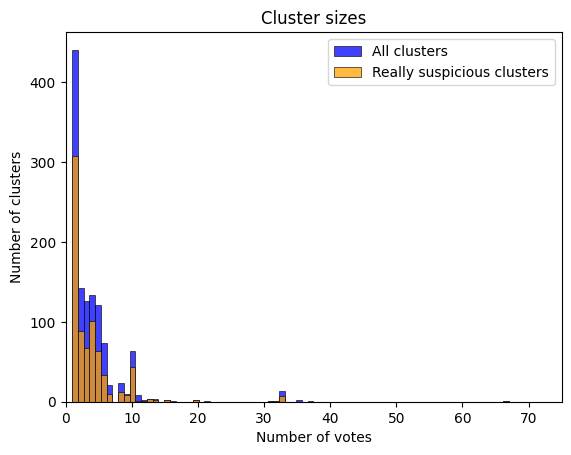

In [777]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.histplot(df_suspicious_votes.voter.value_counts(), color='blue', label='All clusters', kde_kws={'clip': (0.0, 75.0)}, bins=76)
sns.histplot(df_suspicious_votes[df_suspicious_votes['really_suspicicious_cluster']].voter.value_counts(), color='orange', label='Really suspicious clusters', kde_kws={'clip': (0.0, 75.0)}, bins=76)
plt.title('Cluster sizes')
plt.xlabel('Number of votes')
plt.ylabel('Number of clusters')
plt.xlim(0, 75)
plt.legend()
plt.show()

In [778]:
df_suspicious_votes.groupby('cluster_number').count()['tx_hash'].describe()

count    161.000000
mean      29.472050
std       86.526084
min        2.000000
25%        4.000000
50%        9.000000
75%       19.000000
max      741.000000
Name: tx_hash, dtype: float64

In [779]:
df_suspicious_votes[df_suspicious_votes['really_suspicicious_cluster']].groupby('cluster_number').count()['tx_hash'].describe()

count     43.000000
mean      65.441860
std      160.080084
min        2.000000
25%        3.000000
50%        5.000000
75%       20.000000
max      741.000000
Name: tx_hash, dtype: float64

This method is eliminating many cluster but we are sure not too flag too many addresses that are not sybils.

Let's verify that similar cluster size are not voting for some project in particular.

In [780]:
size_2 = df_suspicious_votes.groupby('cluster_number').count()['tx_hash'] == 2
size_2.sum()

15

In [781]:
df_suspicious_votes[df_suspicious_votes['cluster_number'].isin(size_2[size_2].index)].groupby('project').count()['tx_hash'].sort_values(ascending=False).head(10)

project
0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b    8
0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd    4
0x13257e783dc8ded7e227a28edb0428c42d31202e    2
0x8615b6ed9468cbb58cfdf45c120b87e15add787f    2
0xbec643bd5b7f5e9190617ca4187ef0455950c51c    2
0xe1887ff140bfa9d3b45d0b2077b7471124acd242    2
0x298f7f66ba43f0efecf4bc324b0016f822c783a4    1
0x4486907312143049ac5c6280cba9ba4cd5f30511    1
0x7904667c340601aab73939372c016dc5102732a2    1
0x850a146d7478daaa98fc26fd85e6a24e50846a9d    1
Name: tx_hash, dtype: int64

In [782]:
df_suspicious_votes[~df_suspicious_votes['really_suspicicious_cluster']].groupby('project').count()['tx_hash'].sort_values(ascending=False).head(10)

project
0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b    130
0xe1887ff140bfa9d3b45d0b2077b7471124acd242    125
0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd    121
0xeb0cf83c80e4b4cd82196dac94e2c579672b6b1c    118
0x7904667c340601aab73939372c016dc5102732a2     86
0x88c379caef7965c49b17c2a18c43af36f213fbd5     75
0x13257e783dc8ded7e227a28edb0428c42d31202e     69
0x298f7f66ba43f0efecf4bc324b0016f822c783a4     67
0x8615b6ed9468cbb58cfdf45c120b87e15add787f     66
0x91fbd3447077bfd97f5af4d2c033ecbc25788f89     62
Name: tx_hash, dtype: int64

We should check these projects, after reviewing the name of the projects those highest values corresponds to Karma, Bankless x2, Biteye. We will consider that these projects are not sybil. and flag only really suspicious addresses. 

Here the point is: does it make sense to squelche all the votes of these addresses or not? Probably, these clsuter should be matched as only one voter and not multiple votes. Then aggregate the USD amount for each project. This way we prevent squeching votes to some projects and prevent the sybil attack of the cluster.

We will le the round manager decide

### Verify large clusters 
Now for the largest cluster we verify that the seed address is not a cex or bridge address. If it is we will not flag the cluster.

In [783]:
array_unique_seeder = df_seed.from_address.unique()

In [784]:
df_suspicious_votes[df_suspicious_votes['really_suspicicious_cluster']].groupby('cluster_number').count()['tx_hash'].sort_values(ascending=False).head(10)

cluster_number
14     741
6      599
40     448
29     292
22     168
28     144
120    104
138     46
92      42
18      30
Name: tx_hash, dtype: int64

In [785]:
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 14].drop_duplicates(subset=['voter'])

,block_timestamp,tx_hash,voter,project,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number,really_suspicicious_cluster
753,2023-06-27T14:42:43.000Z,0x486fff4db8329c85b5ae822cafda1cfd6ed18408aacf...,0x218e35011c1521151fdc1f51d1079fb67938b542,0x924f5821f991f366df954536e9a408867f962637,1.127814,753,True,True,False,False,False,True,0,0,0.0,0.0,False,11,0,False,False,False,0,False,0,0,False,False,False,False,True,False,True,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
1104,2023-06-27T04:12:41.000Z,0x35f5aef5b6153a7de3d1e24bde78810d953adc6df800...,0x5a8821d4e18d159ad05747fffd6493575ca40809,0xdc71a1bdeabd3c347dc21e9354aff91ad375eb97,2.669159,1104,False,True,True,False,False,True,0,0,0.0,0.0,False,3,0,False,False,True,0,False,0,0,False,False,False,False,True,False,True,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
1868,2023-06-27T15:04:59.000Z,0x3f7843ac699ad7901888279d7efa797daf5f36b6edbb...,0xa9186bfc3d42d065f000571b7e7bbd725d7cef45,0xca72c93172ba6eff168e59e7f17c3c7a8fea9b62,1.127814,1868,True,True,False,False,False,True,0,0,0.0,0.0,False,0,0,False,False,True,0,False,0,0,False,False,False,False,True,False,True,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
1992,2023-06-27T21:32:51.000Z,0xc61c705f2a30c8aa6b60d0b33ac78542021d938ec97c...,0x04a7e68fe117248f10fecf7d1a937a50608d3e00,0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b,1.052626,1992,True,True,False,False,False,True,0,0,0.0,0.0,False,1,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
2060,2023-06-27T14:47:15.000Z,0x9a90b9f3c7dee1e62c4f0cb950c52dfff759c6799846...,0xd5ddb86dd668dd3abf42acbbd239330ea5b04f8c,0x8d36bbb74973dd04e31dcbce5778b16dd310bd9b,1.127814,2060,True,True,False,False,False,True,0,0,0.0,0.0,False,1,0,False,False,True,0,False,0,0,False,False,False,False,True,False,True,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55258,2023-06-13T21:22:33.000Z,0x8bf54e9a32e5a3d9d997fb23058908604be5a652c100...,0xd4daf805859cae69249982c7bf30491c77232bd3,0x7904667c340601aab73939372c016dc5102732a2,1.743521,55258,True,True,False,False,False,True,0,0,0.0,0.0,False,4,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
55389,2023-06-26T07:04:21.000Z,0x568519dc981b4a4709a3f88f11a4841cf3c6f1966342...,0x73125974604de547afbca461fec66f7492f014f8,0xeb0cf83c80e4b4cd82196dac94e2c579672b6b1c,2.317135,55389,False,True,True,False,False,True,0,0,0.0,0.0,False,3,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
55465,2023-06-27T21:29:51.000Z,0xac876d25da34e3085a338928fc8c93dc25564cd80134...,0x9727d0baad3b7c0161aca7866915bca6a5c9546b,0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b,1.022551,55465,True,True,False,False,False,True,0,0,0.0,0.0,False,4,0,False,False,True,0,False,0,0,False,False,False,False,False,False,False,True,"[0x024214fbc5f2b5b9b33edbcfe224cfe31de15c56, 0...",14,True
56755,2023-06-19T05:00:27.000Z,0x3e9187d38da46c5e92723ea14a404866025959ddd7cb...,0x1626255e55b3c8fa14c933646534e9f8726c649a,0xbec643bd5b7f5e9190617ca4187ef0455950c51c,11.216730,56755,True,True,False,False,False,True,0,0,0.0,0.0,False,41

In [786]:
s_cluster = df_suspicious_votes[df_suspicious_votes['cluster_number'] == 14]['cluster_address'].values[0]

In [787]:
np.intersect1d(s_cluster, array_unique_seeder).shape

(56,)

For sure this one is a sybil. It has seeded many addresses. We will flag it.

In [788]:
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 14].groupby('project').sum()['amount_usd'].sort_values(ascending=False).head(10)

project
0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd    93.661567
0xe1887ff140bfa9d3b45d0b2077b7471124acd242    82.091363
0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b    80.060315
0xeb0cf83c80e4b4cd82196dac94e2c579672b6b1c    75.752538
0xbec643bd5b7f5e9190617ca4187ef0455950c51c    46.141060
0x88c379caef7965c49b17c2a18c43af36f213fbd5    40.440884
0xfc9265a28f66cf4561d74a4e25d7bbd3f482b8e6    28.055847
0x850a146d7478daaa98fc26fd85e6a24e50846a9d    24.688444
0xc4450c8d1009160883e44f24d66d92436ae4b4c5    23.876237
0x298f7f66ba43f0efecf4bc324b0016f822c783a4    23.772672
Name: amount_usd, dtype: float64

This is hard to tell 

In [789]:
df_suspicious_votes[df_suspicious_votes['cluster_number'] == 14].groupby(['project', 'voter']).count().sort_values(by='tx_hash', ascending=False).head(10)

,,block_timestamp,tx_hash,amount_usd,__row_index,seed_same_naive,seed_same,seed_suspicious,less_5_tx,less_10_tx,interacted_other_ctbt,lcs,cluster_size_lcs,mean_score_lcs,max_score_lcs,has_lcs,count_interaction_with_pool,count_interaction_with_toxic,interact_less_5tx,has_interaction_toxic,has_no_pool_interaction,count_interaction_with_airdrop_m,is_airdrop_master,count_interaction_with_tornado,count_interaction_with_disperse,has_interaction_airdrop_m,has_interaction_tornado,has_interaction_disperse,flagged,stakeridoo_detected,doge_detected,odc_detected,has_seed_cluster,cluster_address,cluster_number,really_suspicicious_cluster
project,voter,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0x13257e783dc8ded7e227a28edb0428c42d31202e,0x218e35011c1521151fdc1f51d1079fb67938b542,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0x924f5821f991f366df954536e9a408867f962637,0x218e35011c1521151fdc1f51d1079fb67938b542,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0x745ce2af76e9a6eba65cc0cacaa9ea109bb7fabd,0x218e35011c1521151fdc1f51d1079fb67938b542,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0x298f7f66ba43f0efecf4bc324b0016f822c783a4,0x9fc11979dc18ce13a6aeff86666cfb4cb230994b,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0xeb0cf83c80e4b4cd82196dac94e2c579672b6b1c,0x218e35011c1521151fdc1f51d1079fb67938b542,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0x8615b6ed9468cbb58cfdf45c120b87e15add787f,0x218e35011c1521151fdc1f51d1079fb67938b542,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0xa51e0a99b53d5b00937a2631d5865468a3543b7d,0x218e35011c1521151fdc1f51d1079fb67938b542,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0xc98786d5a7a03c1e74affcb97ff7ef8a710da09b,0x121e1573b7c6c15aa4c036d54bfd2974cf38a163,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
0xb62e762af637b49eb4870bce8fe21bfff189e495,0x763751d86c5f06132a28a71c1992f96725fee374,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [790]:
df_votes.loc[df_suspicious_votes.index, ['cluster_number', 'really_suspicicious_cluster']] = df_suspicious_votes.loc[:, ['cluster_address', 'cluster_number', 'really_suspicicious_cluster']] = df_suspicious_votes.loc[:, ['cluster_address', 'cluster_number', 'really_suspicicious_cluster']]

In [791]:
df_votes['really_suspicicious_cluster'].fillna(False, inplace=True)

In [792]:
print('number of suspicious voters before seed: ', df_votes[df_votes['odc_detected']].voter.unique().shape[0])
print('number squelched votes before seed with odc_detected: ', df_votes[df_votes['odc_detected']].shape[0])

number of suspicious voters before seed:  2407
number squelched votes before seed with odc_detected:  9558


In [793]:
print('Numver of overlapping detection odc/seed: ', df_votes[np.logical_and(df_votes['odc_detected'], df_votes['really_suspicicious_cluster'])].shape[0])
print('Numver of overlapping unique voter odc/seed: ', np.logical_and(df_votes.drop_duplicates(subset=['voter'])['really_suspicicious_cluster'], df_votes.drop_duplicates(subset=['voter'])['odc_detected']).sum())

Numver of overlapping detection odc/seed:  942
Numver of overlapping unique voter odc/seed:  189


In [794]:
df_votes['odc_detected'] = np.logical_or(df_votes['odc_detected'], df_votes['really_suspicicious_cluster'])

In [795]:
print('number of suspicious voters after seed: ', df_votes[df_votes['odc_detected']].voter.unique().shape[0])
print('number squelched votes after seed with odc_detected: ', df_votes[df_votes['odc_detected']].shape[0])

number of suspicious voters after seed:  2976
number squelched votes after seed with odc_detected:  11430


In [796]:
df_votes.to_csv(f'../output_gitcoin/full_features/votes_features_citizen_last_{GRANT_ROUND_ID}.csv', index=False)

In [797]:
df_cluster = df_suspicious_votes[['cluster_number', 'cluster_address', 'really_suspicicious_cluster']].drop_duplicates('cluster_number')
df_cluster["cluster_address"] = df_cluster["cluster_address"].apply(lambda x: json.dumps(x.tolist()))

In [798]:
df_cluster.to_csv(f'../output_gitcoin/full_features/seed_cluster_{GRANT_ROUND_ID}.csv', index=False)